In [ ]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import optuna 


In [33]:
!pip install optuna

  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/e8/30/35111dae435c640694d616a611b7ff6b2482cfd977f8f572ff960a321d66/optuna-4.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/cb/06/8b505aea3d77021b18dcbd8133aa1418f1a1e37e432a465b14c46b2c0eaa/alembic-1.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/e3/51/9b208e85196941db2f0654ad0357ca6388ab3ed67efdbfc799f35d1f83aa/colorlog-6.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for sqlalchemy>=1.4.2 from https://files.pythonhosted.org/packages/b1/03/d12b7c1d36fd80150c1d52e121614cf9377dac99e5497af8d8f5b2a8db64/SQLAlchemy-2.0.36-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/48/22/bc14c6f02e6dccaafb3eba95764c8f096714260c2aa5f76f654fd16a23dd/Mako-1.3.6-py3-no


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: C:\Users\defaultuser0.LAPTOP-LRB3T941\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
data=pd.read_csv("Silver nanomaterils antibacterial  .csv")
data.head()

,Process,Steps,External_energy,Temp_Celcius,Stirring,Synthesis_Duration_h,Scale_synthesis_ml,Precurcor_conc_mM,NEW_Capping agent,NEW_capping agent_Class,...,treatment,UVVIs PEAKS nm,shape,core size (nm),Method of determination_size,exposure dose concentration mg/mL,Exposure duration (h),bacterial Culture medium,bacterial Species,Bacteria reduction mm
0,phytosynthesis,single,No,25,No,4,?,7,plant,organic,...,no,430,spherical,25,SEM,0.01125,?,MuellerHinton,Enterococcus,6.0
1,phytosynthesis,single,No,25,No,4,?,7,plant,organic,...,no,430,spherical,25,SEM,0.0225,?,MuellerHinton,Enterococcus,6.0
2,phytosynthesis,single,No,25,No,4,?,7,plant,organic,...,no,430,spherical,25,SEM,0.01125,?,MuellerHinton,Enterococcus,6.0
3,phytosynthesis,single,Heating,80,Stirring,2,20,1.5,plant,organic,...,no,420,spherical,10,TEM,0.08,24,MuellerHinton,Salmonella,0.0
4,phytosynthesis,single,Heating,80,Stirring,2,20,1.5,plant,organic,...,no,420,spherical,10,TEM,0.04,24,MuellerHinton,Salmonella,0.0


In [24]:
# Count the number of "?" in each column
missing_values = (data == '?').sum()/len(data) *100
print(missing_values)

Process                               0.000000
Steps                                 0.000000
External_energy                       0.000000
Temp_Celcius                          3.756994
Stirring                              0.000000
Synthesis_Duration_h                 11.350919
Scale_synthesis_ml                   40.607514
Precurcor_conc_mM                     2.398082
NEW_Capping agent                     0.000000
NEW_capping agent_Class               0.959233
NEW_reducing agent                    1.438849
NEW_reducing agent_class              1.438849
Capping agent concentration_mg/mL    34.052758
Reducing agent quantity mL           41.646683
Order of reagent_CODE                 7.114309
treatment                             0.159872
UVVIs PEAKS nm                        6.075140
shape                                 9.192646
core size (nm)                        9.352518
Method of determination_size         10.311751
exposure dose concentration mg/mL    16.227018
Exposure dura

In [5]:

categorical_cols = ['Process',"NEW_Capping agent", "NEW_reducing agent_class" ,"Order of reagent_CODE",'Steps', 'External_energy', 'Stirring', 'NEW_Capping agent', 'NEW_capping agent_Class', 'treatment', 'shape', 'Method of determination_size', 'bacterial  Culture medium', 'bacterial  Species']
data.replace('?', np.nan, inplace=True)

for col in categorical_cols:
    data[col] = data[col].astype('category')
object_cols = data.select_dtypes(['object']).columns

# Convert object columns to numeric
for cols in object_cols:
    try:
        data[cols] = pd.to_numeric(data[cols])
    except:
        pass
        #print(cols)
#data["Temp_Celcius"] = pd.to_numeric(data["Temp_Celcius"])
data["NEW_reducing agent"]=data["NEW_reducing agent"].astype("category")
print(data.dtypes)

Process                              category
Steps                                category
External_energy                      category
Temp_Celcius                          float64
Stirring                             category
Synthesis_Duration_h                  float64
Scale_synthesis_ml                    float64
Precurcor_conc_mM                     float64
NEW_Capping agent                    category
NEW_capping agent_Class              category
NEW_reducing agent                   category
NEW_reducing agent_class             category
Capping agent concentration_mg/mL     float64
Reducing agent quantity mL            float64
Order of reagent_CODE                category
treatment                            category
UVVIs PEAKS nm                        float64
shape                                category
core size (nm)                        float64
Method of determination_size         category
exposure dose concentration mg/mL     float64
Exposure duration  (h)            

%Do train test split first , and then do imputation 

In [29]:
X=data.drop(columns=["Bacteria reduction mm"])
Y=data["Bacteria reduction mm"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=666)

#convert the numerical datas to number ,and the categorical data


In [ ]:
#data2=data.copy()
categoricical_COLS=[i for i in data.columns if data[i].dtype.name == 'category']
label_encoder = LabelEncoder()
encoded_cols=[]
for col in categoricical_COLS:
    X_train[col + '_encoded'] = label_encoder.fit_transform(X_train[col].astype(str))
    X_test[col + '_encoded'] = label_encoder.transform(X_test[col].astype(str))

    encoded_cols.append(col + '_encoded')
    
X_train.drop(categoricical_COLS, axis=1, inplace=True)
X_test.drop(categoricical_COLS,axis=1 , inplace=True)
X_train.head()

,Temp_Celcius,Synthesis_Duration_h,Scale_synthesis_ml,Precurcor_conc_mM,Capping agent concentration_mg/mL,Reducing agent quantity mL,UVVIs PEAKS nm,core size (nm),exposure dose concentration mg/mL,Exposure duration (h),...,NEW_Capping agent_encoded,NEW_capping agent_Class_encoded,NEW_reducing agent_encoded,NEW_reducing agent_class_encoded,Order of reagent_CODE_encoded,treatment_encoded,shape_encoded,Method of determination_size_encoded,bacterial Culture medium_encoded,bacterial Species_encoded
1109,70.0,72.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,3,6,1,1,4,6,8,2,32
1238,25.0,5.00,NaN,10.0,10.0,NaN,430.0,24.00,0.050,24.0,...,8,3,7,2,7,6,7,6,4,32
857,60.0,0.33,110.0,1.0,1.0,10.0,425.0,17.85,NaN,24.0,...,8,3,7,2,3,7,7,5,4,32
317,121.0,0.25,100.0,1.0,NaN,10.0,410.0,NaN,0.015,24.0,...,1,3,0,2,3,4,7,8,0,14
314,25.0,24.00,100.0,1.0,NaN,100.0,440.0,NaN,NaN,24.0,...,6,3,5,2,3,4,6,8,0,14


In [32]:
from sklearn.impute import  KNNImputer
imputer = KNNImputer(n_neighbors=5)
TRAIN_IMPOTED = imputer.fit_transform(X_train)
TRAIN_IMPOTED = pd.DataFrame(TRAIN_IMPOTED, columns=X_train.columns)
Test_IMPOTED = imputer.transform(X_test)
Test_IMPOTED = pd.DataFrame(Test_IMPOTED, columns=X_test.columns)
for cols in TRAIN_IMPOTED.columns:
    if cols in encoded_cols:
        TRAIN_IMPOTED[cols]=label_encoder.inverse_transform(TRAIN_IMPOTED[cols].astype(int))
        Test_IMPOTED[cols]=label_encoder.inverse_transform(Test_IMPOTED[cols].astype(int))
TRAIN_IMPOTED.head()

,Temp_Celcius,Synthesis_Duration_h,Scale_synthesis_ml,Precurcor_conc_mM,Capping agent concentration_mg/mL,Reducing agent quantity mL,UVVIs PEAKS nm,core size (nm),exposure dose concentration mg/mL,Exposure duration (h),...,NEW_Capping agent_encoded,NEW_capping agent_Class_encoded,NEW_reducing agent_encoded,NEW_reducing agent_class_encoded,Order of reagent_CODE_encoded,treatment_encoded,shape_encoded,Method of determination_size_encoded,bacterial Culture medium_encoded,bacterial Species_encoded
0,70.0,72.00,120.0,1.0,60.4,20.0,442.8,26.60,0.077158,14.4,...,Actinomycetes,Agrobacterium tumefaciens,Calcateuticals anitratus,Actinomycetes,Actinomycetes,Aspergillus,Calcateuticals anitratus,Candida,Aeromonas,Staphylococcus
1,25.0,5.00,90.0,10.0,10.0,9.0,430.0,24.00,0.050000,24.0,...,Candida,Agrobacterium tumefaciens,Campylobacter,Aeromonas,Campylobacter,Calcateuticals anitratus,Campylobacter,Calcateuticals anitratus,Aspergillus,Staphylococcus
2,60.0,0.33,110.0,1.0,1.0,10.0,425.0,17.85,0.030000,24.0,...,Candida,Agrobacterium tumefaciens,Campylobacter,Aeromonas,Agrobacterium tumefaciens,Campylobacter,Campylobacter,Bacillus,Aspergillus,Staphylococcus
3,121.0,0.25,100.0,1.0,100.8,10.0,410.0,5.36,0.015000,24.0,...,Actinomycetes,Agrobacterium tumefaciens,Acinetobacter,Aeromonas,Agrobacterium tumefaciens,Aspergillus,Campylobacter,Candida,Acinetobacter,Escherichia coli
4,25.0,24.00,100.0,1.0,25.0,100.0,440.0,3.00,326.000000,24.0,...,Calcateuticals anitratus,Agrobacterium tumefaciens,Bacillus,Aeromonas,Agrobacterium tumefaciens,Aspergillus,Calcateuticals anitratus,Candida,Acinetobacter,Escherichia coli


In [33]:
for cols in  TRAIN_IMPOTED.columns:
    if cols in encoded_cols:
        TRAIN_IMPOTED[cols]=TRAIN_IMPOTED[cols].astype('category')
        Test_IMPOTED[cols]=Test_IMPOTED[cols].astype('category')

In [34]:
TRAIN_IMPOTED.dtypes

Temp_Celcius                             float64
Synthesis_Duration_h                     float64
Scale_synthesis_ml                       float64
Precurcor_conc_mM                        float64
Capping agent concentration_mg/mL        float64
Reducing agent quantity mL               float64
UVVIs PEAKS nm                           float64
core size (nm)                           float64
exposure dose concentration mg/mL        float64
Exposure duration  (h)                   float64
Process_encoded                         category
Steps_encoded                           category
External_energy_encoded                 category
Stirring_encoded                        category
NEW_Capping agent_encoded               category
NEW_capping agent_Class_encoded         category
NEW_reducing agent_encoded              category
NEW_reducing agent_class_encoded        category
Order of reagent_CODE_encoded           category
treatment_encoded                       category
shape_encoded       

MAking and ensemble model, or i should train optuna first

In [ ]:

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 17),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10)
    }
    lgb_train = lgb.Dataset(TRAIN_IMPOTED, y_train, categorical_feature=encoded_cols)
    #lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature=categorical_cols)
    
    gbm = lgb.train(param, lgb_train)
    
    preds = gbm.predict(TRAIN_IMPOTED, num_iteration=gbm.best_iteration)
    rmse = mean_squared_error(TRAIN_IMPOTED , preds,squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000,n_jobs=-1)

print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2024-11-29 16:51:00,926] A new study created in memory with name: no-name-cdf14012-3ff9-4766-a9f8-278be28167ae
[W 2024-11-29 16:51:01,087] Trial 4 failed with parameters: {'learning_rate': 0.02792508061620834, 'num_leaves': 101, 'max_depth': 17, 'min_data_in_leaf': 69, 'feature_fraction': 0.37723019286297177, 'bagging_fraction': 0.11033464266038497, 'bagging_freq': 10} because of the following error: ValueError('y_true and y_pred have different number of output (24!=1)').
Traceback (most recent call last):
  File "C:\Users\defaultuser0.LAPTOP-LRB3T941\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\defaultuser0.LAPTOP-LRB3T941\AppData\Local\Temp\ipykernel_25176\278624630.py", line 20, in objective
    rmse = mean_squared_error(TRAIN_IMPOTED , preds,squared=False)
          

ValueError: y_true and y_pred have different number of output (24!=1)

In [50]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

params=trial.params
model=lgb.LGBMRegressor(**params)
#model2=lgb.LGBMRegressor()
tests=[]
y_preds=[]
y_rmse=[]
for i in range(1 , 10):
    X_train2, X_test2, y_train2, y_test2 = train_test_split(TRAIN_IMPOTED, y_train, test_size=i/10, random_state=666)
    tests.append(f"{i*10}")
    y_predss = model.fit(X_train2, y_train2).predict(X_test2)
    r2=r2_score(y_test2 , y_predss)
    msse=mean_squared_error(y_test2,y_predss)
    y_rmse.append(msse)
    y_preds.append(r2)
#y_predss2 = model2.fit(X_train2, y_train2).predict(X_test2)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.932801685003951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.932801685003951
[LightGBM] [Warning] bagging_fraction is set=0.9696626035117994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9696626035117994
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.932801685003951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.932801685003951
[LightGBM] [Warning] bagging_fraction is set=0.9696626035117994, subsample=1.0 will be ignored. Current value: baggin

y_preds

In [51]:
y_preds

[0.8020721596445224,
 0.7654975319596934,
 0.7662349065812885,
 0.7333631606929623,
 0.7001803103481985,
 0.5925087179862408,
 0.5824151427755885,
 0.4968821726670487,
 0.22939335137741879]

Text(0, 0.5, 'R2 score')

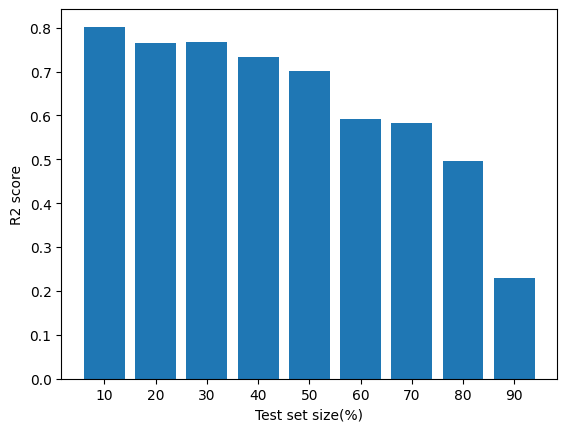

In [44]:

plt.bar(x=tests ,height=y_preds )
plt.xlabel("Test set size(%)")
plt.ylabel("R2 score")
#print(f'R² value: {r2}')

Text(0, 0.5, 'Rmse')

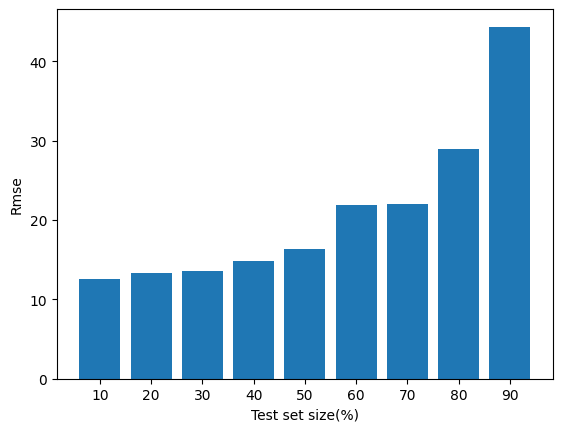

In [52]:

plt.bar(x=tests ,height=y_rmse )
plt.xlabel("Test set size(%)")
plt.ylabel("Rmse")


In [47]:
params=trial.params
#model=lgb.LGBMRegressor(**params)
#model.fit(, y_train)
params

{'learning_rate': 0.09997749761631024,
 'num_leaves': 137,
 'max_depth': 12,
 'min_data_in_leaf': 10,
 'feature_fraction': 0.932801685003951,
 'bagging_fraction': 0.9696626035117994,
 'bagging_freq': 8}